# Varying Dimension of Latent Space

## Preparing

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as kb
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
(X_train, _), (X_test, labels_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
labels_name = {0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}



In [9]:
def CreateEncoder(channel):
    input_img = Input(shape=(32,32,3))
    # model: encoder
    encoded = Conv2D(64, (3, 3), activation='relu', 
                                    padding='same')(input_img)
    #encoded = Conv2D(64, (3, 3), activation='relu', 
    #                                padding='same')(encoded)
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(32, (3, 3), activation='relu', 
                                    padding='same')(encoded)
    #encoded = Conv2D(32, (3, 3), activation='relu', 
    #                                padding='same')(encoded)                                
    encoded = MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = Conv2D(channel, (3, 3), activation='relu', padding='same')(encoded)

    #input_encoded_before_flatten = kb.int_shape(encoded)
    encoded = Flatten()(encoded)
    #encoded = Dense(dim, activation='relu')(encoded)
    encoder = Model(input_img, encoded)

    return encoder

def CreateDecoder(channel):
    # model: decoder
    input_encoded = Input(shape=(channel*8*8,))
    #decoded = Dense(512, activation='relu')(input_encoded)
    decoded = Reshape((8,8,channel))(input_encoded)
    decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = UpSampling2D((2, 2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
    decoder = Model(input_encoded, decoded)

    return decoder



## Loop

In [10]:
channels = [8, 7, 6, 5, 4, 1]
ephochs = [20, 15, 10, 10, 10, 10]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0005)

lucky_sample = 1;
decoded_samples = np.zeros((len(channels),32,32,3))
loss_test = np.zeros(len(channels))
input_img = Input(shape=(32,32,3))

for i in range(len(channels)):
    channel = channels[i]
    ephoch = ephochs[i]
    encoder = CreateEncoder(channel)
    decoder = CreateDecoder(channel)

    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = Model(input_img, decoded)

    optimizer = Adam(learning_rate=0.002)
    bce = tf.keras.losses.BinaryCrossentropy()
    mse = tf.keras.losses.MeanSquaredError()

    autoencoder.compile(optimizer=optimizer, loss=bce)

    autoencoder.fit(X_train, X_train,
                epochs=ephoch,
                batch_size=128,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping], # stop the training when no improvements are made
                verbose=1)
    
    # save model
    save_filepath = 'model/cifar10_ae/varying_dim/'+str(channel)+'_channels'
    autoencoder.save(
        filepath=save_filepath,
        overwrite=True,
        include_optimizer=True,
    )

    decoded_sample = autoencoder.predict(X_test[lucky_sample].reshape(-1,32,32,3))
    decoded_samples[i] = decoded_sample
    decoded_imgs = autoencoder.predict(X_test)
    loss_test[i] = bce(X_test.reshape(-1,32*32*3),decoded_imgs.reshape(-1,32*32*3)).numpy()
    i = i+1



Epoch 1/20
391/391 [==============================] - 9s 16ms/step - loss: 0.5977 - val_loss: 0.5659
Epoch 2/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5652 - val_loss: 0.5620
Epoch 3/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5609 - val_loss: 0.5605
Epoch 4/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5597 - val_loss: 0.5598
Epoch 5/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5583 - val_loss: 0.5587
Epoch 6/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5586 - val_loss: 0.5585
Epoch 7/20
391/391 [==============================] - 5s 14ms/step - loss: 0.5581 - val_loss: 0.5581
Epoch 8/20
391/391 [==============================] - 5s 14ms/step - loss: 0.5571 - val_loss: 0.5596
Epoch 9/20
391/391 [==============================] - 5s 14ms/step - loss: 0.5569 - val_loss: 0.5574
Epoch 10/20
391/391 [==============================] - 5s 14ms/step - loss: 0.5563 - val_lo

## Plot

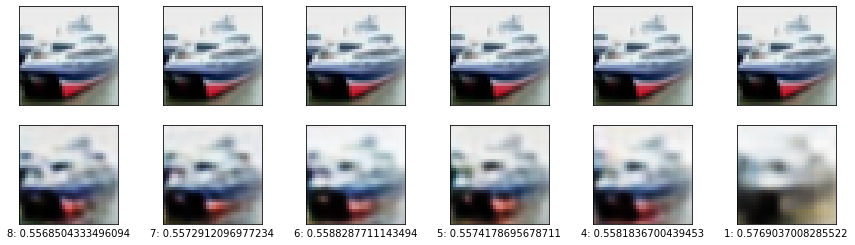

In [15]:
n = len(channels)  # how many images we will display
plt.figure(figsize=(15, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[1])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_samples[i].reshape(32,32,3))
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel = str(channels[i])+': '+str(loss_test[i])
    ax.set_xlabel(xlabel)
plt.savefig('images/cifar10_ae/cifar10_with_diff_latent_dim.png', dpi=120)
plt.show()